# SOMs for Beginners
The following notebook contains an elementary SOM for learning purposes. 
The data: 
* c0_gen_nomag.hdf5
* c1_gen_nomag.hdf5 
* c2_gen_nomag.hdf5
* c3_gen_nomag.hdf5 

The above contain the mags for different tomographic redshift bins. 
Path: 

`/Users/diana/Research/DESI-SOM/data/Other` (Change to be the path where you are storing your data. It's good book-keeping.) 
    
Other things to note: 
* Each cell in the SOM (for the photo-z callibration) represents a galaxy phenotype. 
* Tomographic bins refer to populations of galaxies with similar properties (like, colors, SEDs), rather than directly similar spectroscopic redshifts. 

In [1]:
# import functions

import sys
sys.path.append('/opt/anaconda3/lib/python3.8/site-packages') # minisom location
                                                              # might need to change 
                                                              # if minisom can't be found

from astropy.table import Table, vstack

import h5py

import matplotlib.pyplot as plt
%matplotlib inline

from minisom import MiniSom

import numpy as np

from unittest import mock

In [2]:
# data path 
path = '/Users/diana/Research/DESI-SOM/data/Other'

c0_gen = h5py.File(f'{path}/c0_gen_nomag.hdf5', 'r')
c1_gen = h5py.File(f'{path}/c1_gen_nomag.hdf5', 'r')
c2_gen = h5py.File(f'{path}/c2_gen_nomag.hdf5', 'r')
c3_gen = h5py.File(f'{path}/c3_gen_nomag.hdf5', 'r')

In [3]:
# list keys
print(list(c0_gen.keys()))
print(c0_gen['catalog.__table_column_meta__'])

['catalog', 'catalog.__table_column_meta__']
<HDF5 dataset "catalog.__table_column_meta__": shape (17,), type "|S38">


In [4]:
# convert into np arrays for ease of access 
c0_gen_rows = np.array(c0_gen['catalog'][:])
c1_gen_rows = np.array(c1_gen['catalog'][:])
c2_gen_rows = np.array(c2_gen['catalog'][:])
c3_gen_rows = np.array(c3_gen['catalog'][:])

In [5]:
# convert to astropy Table for even easier access...
c0_gen = Table(rows=c0_gen_rows, names=('ztrue', 'mu', 'gamma_1', 'gamma_2', 'ra', 'dec', 'mag', 'z_fib_mag', 'r_fib_mag', 'random_2', 'g_1', 'g_2', 'e_1', 'e_2', 'z', 'w'))
c1_gen = Table(rows=c1_gen_rows, names=('ztrue', 'mu', 'gamma_1', 'gamma_2', 'ra', 'dec', 'mag', 'z_fib_mag', 'r_fib_mag', 'random_2', 'g_1', 'g_2', 'e_1', 'e_2', 'z', 'w'))
c2_gen = Table(rows=c2_gen_rows, names=('ztrue', 'mu', 'gamma_1', 'gamma_2', 'ra', 'dec', 'mag', 'z_fib_mag', 'r_fib_mag', 'random_2', 'g_1', 'g_2', 'e_1', 'e_2', 'z', 'w'))
c3_gen = Table(rows=c3_gen_rows, names=('ztrue', 'mu', 'gamma_1', 'gamma_2', 'ra', 'dec', 'mag', 'z_fib_mag', 'r_fib_mag', 'random_2', 'g_1', 'g_2', 'e_1', 'e_2', 'z', 'w'))

In [6]:
# vertically stack datasets 
c_gen = vstack([c0_gen, c1_gen, c2_gen, c3_gen])

In [7]:
target = c_gen['ztrue']
c_gen_data = c_gen['mag']

In [8]:
# data normalization
c_gen_data = np.array((c_gen_data - np.mean(c_gen_data, axis=0)) / np.std(c_gen_data, axis=0))
print(c_gen_data)

[[-5.8301735  -5.7676663  -5.4662313  ... -5.2435064  -3.7976618
  -3.8107374 ]
 [-3.4747841  -3.149224   -2.8333085  ... -2.5478761  -1.4826025
  -1.5583926 ]
 [-2.746842   -2.0637076  -1.6535805  ... -1.1148759  -0.11858828
  -0.3130964 ]
 ...
 [ 0.88992274  1.1842724   1.0708268  ...  1.1423187   0.86672497
   0.8788134 ]
 [ 0.6524971   1.0099058   0.98446184 ...  1.121809    0.64534676
   0.60851353]
 [ 1.7208978   1.4836047   1.1401154  ...  1.158445    0.9244251
   0.95705086]]


In [9]:
# shape of data
c_gen_data.shape[1]

7

In [10]:
# initialization and training
n_neurons = 20
m_neurons = 20

som = MiniSom(n_neurons, m_neurons, c_gen_data.shape[1], sigma=1.5, learning_rate=.5, 
              neighborhood_function='gaussian', random_seed=0)
som.pca_weights_init(c_gen_data) # initializes weights to span th first two principal components
som.train(c_gen_data, 10000, verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.3458912002299412


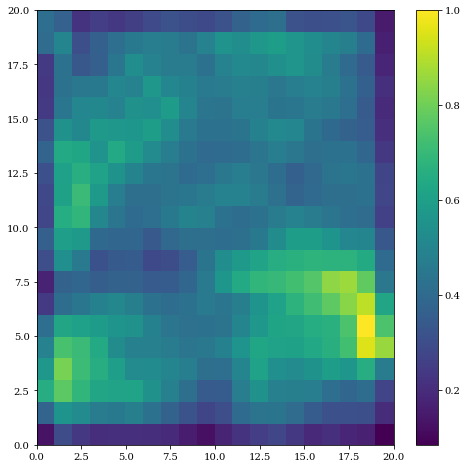

In [11]:
plt.figure(figsize=(8, 8))

plt.pcolor(som.distance_map(), cmap='viridis')  # plotting the distance map as background

plt.colorbar()

plt.show()

In [12]:
win_map = som.win_map(c_gen_data, return_indices = True) # returns a dictionary with all indices of the elements 
                                                         # that have been mapped to the position (i,j) 

In [13]:
# create empty "map" to hold mean z true 
mean_z_map = np.zeros(som.distance_map().shape)
#print(mean_z_map)

for iy, ix in np.ndindex(mean_z_map.shape): 
    #print(mean_z_map[iy, ix]) 
    mean_z_map[iy, ix] = np.mean(c_gen[win_map[(iy, ix)]]['ztrue'])

/Users/diana/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3438: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/diana/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


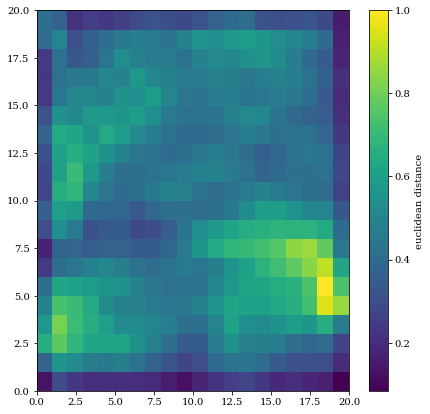

In [14]:
plt.figure(figsize=(7, 7))

plt.pcolor(som.distance_map(), cmap='viridis')  # plotting the distance map as background

cbar = plt.colorbar()
cbar.set_label('euclidean distance') # distance between neuron and neighboring cells 

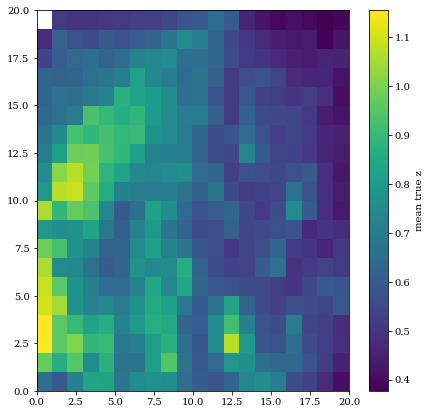

In [15]:
plt.figure(figsize=(7, 7))

plt.pcolor(mean_z_map, cmap='viridis')  # plotting the mean true zs in each tomographic bin

cbar = plt.colorbar()
cbar.set_label('mean true z') 

In [16]:
# now, rather than using the magnitudes, use the colors? 
# mags are HSC g,r,i,z,y,w1,w2
#               0,1,2,3,4,5 ,6

In [20]:
c_gen_data = c_gen['mag']

In [21]:
#print(c_gen_data[0])
#print(c_gen_data[0][0] - c_gen_data[0][1])
#print(len(c_gen_data))
#length = len(c_gen_data)
#width = len(c_gen_data[0])
#print(width)
#c_gen_colors = np.zeros((length, width - 1)) # generate an empty array with dimensions we want

#for i, obj 

In [34]:
# create table or giant list with colors
c_gen_colors = np.zeros((298658, 6))
for i, obj in enumerate(c_gen_data): 
    for j, color in enumerate(c_gen_colors[i]): 
        c_gen_colors[i][j] = (c_gen_data[i][j]-c_gen_data[i][j+1])

In [35]:
c_gen_data[0]

array([18.476446, 17.39126 , 16.994602, 16.72616 , 16.619293, 16.804579,
       17.122272], dtype=float32)

In [36]:
# data normalization
c_gen_colors = np.array((c_gen_colors - np.mean(c_gen_colors, axis=0)) / np.std(c_gen_colors, axis=0))
print(c_gen_colors)

[[ 0.29658854 -0.82241516 -0.37762853 -0.26041443 -1.57779972  0.67873401]
 [-0.73642434 -1.16677411 -1.02397871 -0.69246401 -1.77778457  0.89522551]
 [-1.93064861 -1.72849543 -2.4608476  -1.49308589 -2.25604441  1.75134732]
 ...
 [-1.00805563  0.41646424 -0.24664102 -0.91954266  0.23571783 -0.23517586]
 [-1.1876107   0.01683614 -0.63921789 -0.92537894  0.80569128  0.23346338]
 [ 0.60512282  1.47759284 -0.03412484 -0.6634476   0.11218874 -0.42669994]]


In [42]:
# initialization and training
n_neurons = 25
m_neurons = 25

som = MiniSom(n_neurons, m_neurons, c_gen_colors.shape[1], sigma=1.5, learning_rate=.5, 
              neighborhood_function='gaussian', random_seed=0)
som.pca_weights_init(c_gen_colors) # initializes weights to span th first two principal components
som.train(c_gen_colors, 100000, verbose=True)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.5069928185832304


In [43]:
win_map = som.win_map(c_gen_colors, return_indices = True) # returns a dictionary with all indices of the elements 
                                                         # that have been mapped to the position (i,j) 

In [44]:
# create empty "map" to hold mean z true 
mean_z_map = np.zeros(som.distance_map().shape)
#print(mean_z_map)

for iy, ix in np.ndindex(mean_z_map.shape): 
    #print(mean_z_map[iy, ix]) 
    mean_z_map[iy, ix] = np.mean(c_gen[win_map[(iy, ix)]]['ztrue'])

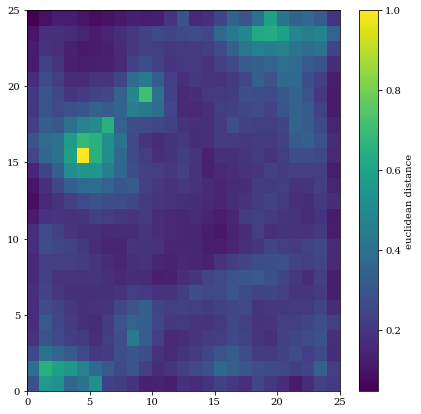

In [45]:
plt.figure(figsize=(7, 7))

plt.pcolor(som.distance_map(), cmap='viridis')  # plotting the distance map as background

cbar = plt.colorbar()
cbar.set_label('euclidean distance') # distance between neuron and neighboring cells 

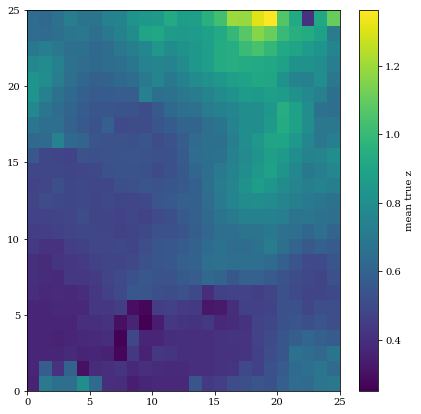

In [46]:
plt.figure(figsize=(7, 7))

plt.pcolor(mean_z_map, cmap='viridis')  # plotting the mean true zs in each tomographic bin

cbar = plt.colorbar()
cbar.set_label('mean true z') 